# Generating geometric median composites (geomedians) <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. 

One approach is to create a [geomedian](https://github.com/daleroberts/hdmedians). 
A `geomedian` is based on a high-dimensional statistic called the 'geometric median' [(Small 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). 
In contrast to a standard median, a geomedian maintains the relationship between spectral bands. 
This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices like NDVI).

## Description
In this notebook we will take of time series of noisy satellite images collected over a year and calculate an annual geomedian composite which is largely free of clouds and other noisy data.

Geomedian computations are expensive in terms of memory, data bandwidth, and cpu usage. The ODC has a useful function, [xr_geomedian](https://github.com/opendatacube/odc-tools/blob/master/libs/algo/odc/algo/_geomedian.py) that allows [dask](https://docs.dask.org/en/latest/) to perform the computation in parallel across many threads to speed things up. In this notebook a `local dask cluster` is used, but the same approach should work using a larger, distributed dask cluster.

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import numpy as np
import datacube
from odc.algo import to_f32, from_float, xr_geomedian
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import rgb
from deafrica_dask import create_local_dask_cluster

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36031 Dashboard: /user/chad/proxy/46061/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Geomedian_composites')

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of cloud-masked Landsat 8 satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. 
This will provide us with some data to work with. To limit computation and memory this example uses only three optical bands (red, green, blue).

In [4]:
# Create a query object
lat, lon = 13.94, -16.54
buffer = 0.25

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2017'),
    'measurements': ['green',
                     'red',
                     'blue'],
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data
ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              dask_chunks={'x': 500, 'y':500},
              output_crs=output_crs,
              align=(15, 15),
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 44 time steps as a dask array
<xarray.Dataset>
Dimensions:  (time: 44, x: 1813, y: 1856)
Coordinates:
  * y        (y) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.514e+06 1.514e+06
  * time     (time) datetime64[ns] 2017-01-06T11:21:53.036448 ... 2017-12-31T11:27:37.598619
  * x        (x) float64 3.064e+05 3.064e+05 3.065e+05 ... 3.608e+05 3.608e+05
Data variables:
    green    (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    red      (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    blue     (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    crs:      epsg:32628


## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot four timesteps of the time series we just loaded.
>Note, this can be quite slow because the dask arrays being plotted must compute first.

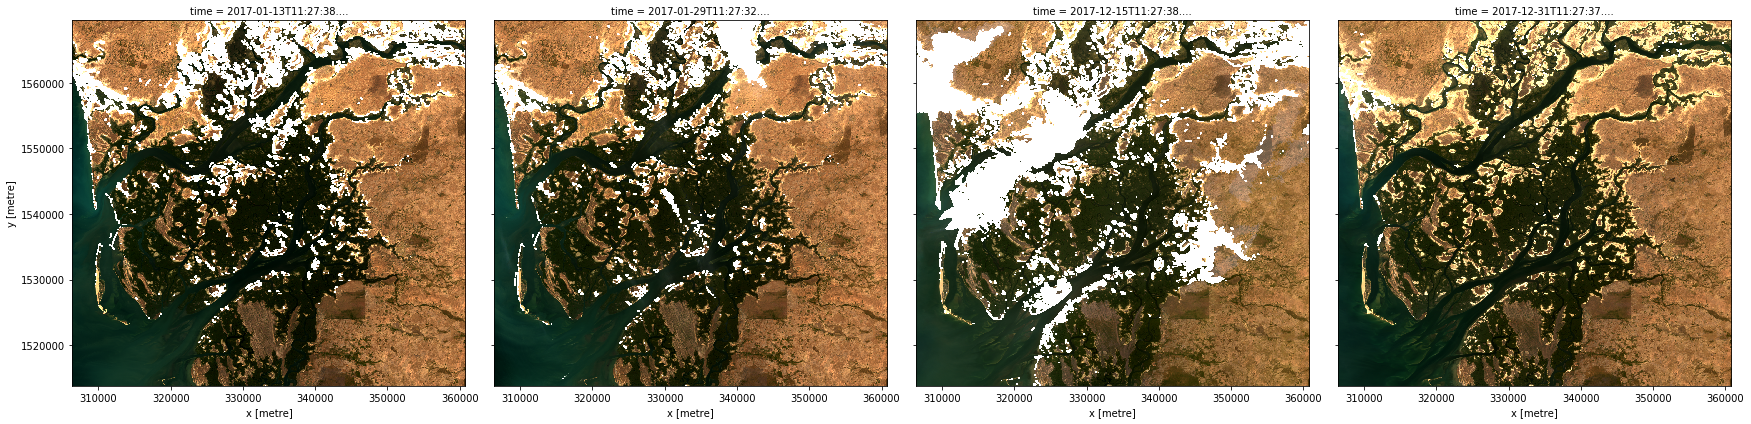

In [5]:
# Set the timesteps to visualise
timesteps = [1, 2, -3, -1]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)


## Generate a geomedian

As you can see above, most satellite images will have at least some areas masked out due to clouds or other interference between the satellite and the ground. 
Generating a geomedian composite will combine all the observations in our `xarray.Dataset` into a single, complete (or near complete) image representing the geometric median of the time period.  This process requires a couple of steps:

1. Before we calculate the geomedian, we first need to prepare the dataset by scaling the surface reflectance values from their original range to `0-1` (DE Africa's Landsat Collection 1 archive is scaled from `0-10,000`, Landsat Collection 2 (not yet available) is scaled from `1-65,455`).  This will ensure numerical stability during the computation.

2. Call the `xr_geomedian` fucntion.  The parameters in the `xr_geomedian` code block do not usually require changing. The `eps` parameter controls the number of iterations to conduct; a good default is `1e-7`.  After calling the function, we then run `.compute()`, which will trigger the computation.

3. Finally, we will convert the result back to the original scaling values (0-10,000 in this example).

In [6]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

#scale the values using the f_32 util function
ds_scaled = to_f32(ds,
                   scale=scale,
                   offset=offset)

In [7]:
#generate a geomedian
geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                         nocheck=True)   # disable checks inside library that use too much ram


### Run the computation

The `.compute()` method will trigger the computation of everything we've instructed above. This will take about a few minutes to run, view the `dask dashboard` to check the progress.

In [8]:
%%time
geomedian = geomedian.compute()

CPU times: user 19.1 s, sys: 1.14 s, total: 20.3 s
Wall time: 3min 47s


In [9]:
#convert SR scaling values back to original values
geomedian = from_float(geomedian, 
                       dtype='float32', 
                       nodata=np.nan, 
                       scale=1/scale, 
                       offset=-offset/scale)

If we print our result, you will see that the `time dimension` has now been removed and we are left with a single image that represents the geometric median of all the satellite images in our initial time series.

In [10]:
print(geomedian)

<xarray.Dataset>
Dimensions:  (x: 1813, y: 1856)
Coordinates:
  * y        (y) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.514e+06 1.514e+06
  * x        (x) float64 3.064e+05 3.064e+05 3.065e+05 ... 3.608e+05 3.608e+05
Data variables:
    green    (y, x) float32 1515.3058 1368.9999 ... 886.17676 921.82544
    red      (y, x) float32 2087.685 1900.0007 1902.2261 ... 1135.3916 1193.8223
    blue     (y, x) float32 993.2564 877.0083 914.8299 ... 496.11737 529.56824


## Plot the geomedian composite

Plotting the result, we can see that the geomedian image is much more complete than any of the individual images. 
We can also use this data in downstream analysis as the relationships between the spectral bands are maintained by the geometric median statistic.


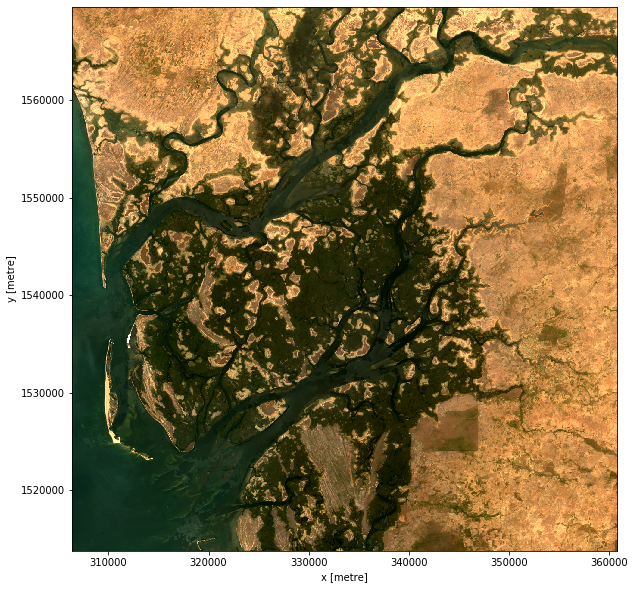

In [11]:
# Plot the result
rgb(geomedian, size=10)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feburary 2020

**Compatible datacube version:**

In [12]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()